## 3.3 Use Transfer Learning

In [1]:
#necessary imports
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#1-Importing the pre-trained model and adding the dense layers.
#We want as many neurons in the last layer of the network as the number of classes we wish to identify.
#So we discard the 1000 neuron layer and add our own last layer for the network -> IncludeTop=False

#imports the MobileNet model and discards the last 1000 neuron layer.
base_model=MobileNet(weights='imagenet',include_top=False) 

# path of the pre-processed imgs
train_path = os.path.join(os.getcwd(), "dataset", "train") # ..\PyClassifier\dataset\train 

# getting classes/labels of the imgs
classes=os.listdir(train_path)
classes.sort()
nb_classes=len(classes)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #dense layers to enable the model learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x)  #dense layer 3
preds=Dense(nb_classes,activation='softmax')(x) #final layer with softmax activation

C:\Anaconda\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [3]:
#preparing the model
from keras.models import load_model

load_saved_model= "false"  # change at your preference
model_path = os.path.join(os.getcwd(), "snapshots", "my_TL_model.h5")

if load_saved_model == "true":
    #load previous saved model
    model = load_model(model_path)  

else:
    #build a new model
    #specify the inputs and outputs to create a model based on our own architecture
    model=Model(inputs=base_model.input,outputs=preds)

print('Done!')


Done!


In [4]:
# We will only be training the last Dense layers that we have made previously
for layer in model.layers:
    layer.trainable=False
    
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [5]:
#2- Loading train data into ImageDataGenerators. 

# ImageDataGenerators are built in keras and help us to train our model
# We just have to specify the path to our training data and it automatically sends the data for training, in batches. 

# input image dimensions
m,n = 128,128  
batch_size= 32

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory(train_path,
                                                 target_size=(m,n), 
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2122 images belonging to 12 classes.


In [6]:
#3- Train and save the model locally 

#train the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
 
step_size_train = train_generator.n//train_generator.batch_size
history =  model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=2,verbose=1)

#save model locally
model.save(model_path)   


Epoch 1/2
66/66 [==============================] - 235s 4s/step - loss: 0.4692 - acc: 0.8920
Epoch 2/2
66/66 [==============================] - 225s 3s/step - loss: 0.2242 - acc: 0.9587


In [7]:
#Evaluate the model
generator_score = model.evaluate_generator(generator=train_generator,steps=step_size_train)
print(generator_score)

# or
loss, accuracy =generator_score
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

[0.12233279752567339, 0.9712918659146322]
Accuracy: 0.971292
Loss: 0.122333


Wall time: 1.1 s


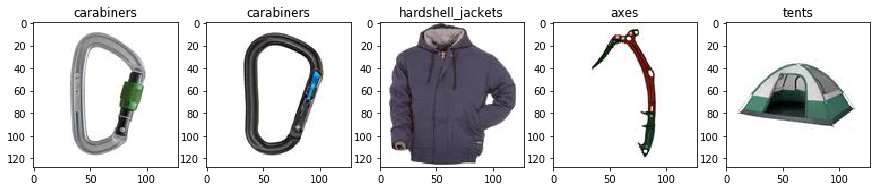

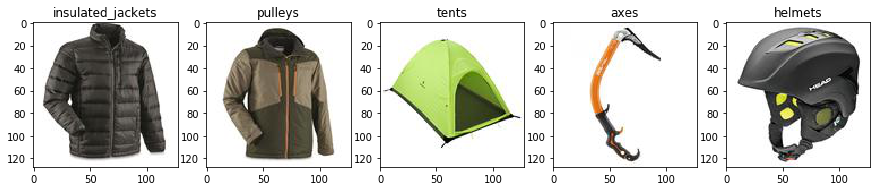

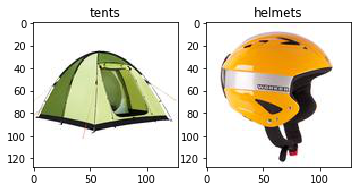

In [8]:
%%time
#predict new Imgs
import glob
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import  img_to_array

# Preprocess the input: Rescale the values to the same range that was used during training 
def preprocess_input(x):
    x = img_to_array(x) / 255.
    return np.expand_dims(x, axis=0) 
    
# Predict an image
def predict_image(im):
    x = preprocess_input(im)
    pred = np.argmax(model.predict(x))
    return pred, classes[pred]

# display img plots as a grid
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(5,5)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

# path to test data
test_path = os.path.join(os.getcwd(), "dataset", "test")   
train_path = os.path.join(os.getcwd(), "dataset", "train") # ..\PyClassifier\dataset\train 
 
images=[] #list of tested imgs
titles=[] #list of imgs' titles predicted

# loop through the test images
for file_ in glob.glob(os.path.join(test_path, "*.*")):
    im = image.load_img(file_, target_size=(m,n))
    images.append(im)

    p, class_name=predict_image(im)
    titles.append(class_name)

grid_display(images, titles, 5, (15,15))


